In [3]:
%%capture
%run naive_algorithm.ipynb
%run features_engineering.ipynb

In [4]:
import random 
import seaborn as sns
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import xgboost as xgb
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from sklearn.preprocessing import StandardScaler,MinMaxScaler

## Split Train/Test

Probleme de segments dans lequel sont compris d'autres segments , pour eviter de la fuite de données dans le cas ou
segment se retrouverais dans le train et une partie de celui ci dans le train : 

* Calcul de jour calendaire/année de chaque segment
* Selection au hasard de certaines dates qui constitueront le test_set , tout le reste dans le train_set
* De cette maniere aucun segment réalisé a une meme date ne pourra se retrouver a la fois dans le train et le test


In [5]:
segments_df.head(5)

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,climb_category,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d
0,14270131,4637673624,10944546,Volcano KOM,654,654,3753.7,76.8,209.3,3.2,...,1,177.9,189.0,18:28:18,2021-01-17,56.82,1,24,0.18,6.67
1,19970445,4637673624,10944546,Volcano Descent,281,281,3507.7,64.5,111.1,-3.4,...,0,151.6,170.0,18:40:17,2021-01-17,56.82,1,24,0.18,6.67
2,22513982,4513379684,10944546,Full Ride,3407,3351,22343.3,80.2,183.4,1.6,...,0,165.2,184.0,18:16:53,2020-12-24,189.82,1,-55,0.83,6.95
3,23240825,4513379684,10944546,"First 3,5 km",763,707,3664.3,78.2,179.8,3.3,...,1,151.0,171.0,18:16:53,2020-12-24,189.82,1,-55,0.83,6.95
4,22745156,4513379684,10944546,rouby - les gorges de la nesque,3183,3127,19504.8,80.1,186.8,2.2,...,0,165.5,184.0,18:16:53,2020-12-24,189.82,1,-55,0.83,6.95


In [6]:
calendar_days = []
for date in segments_df['start_date']:
    calendar_day = date.strftime('%j%Y')
    calendar_days.append(calendar_day)

segments_df['calendar_day'] = calendar_days

In [7]:
dates = segments_df['calendar_day'].unique()

In [8]:
dates = dates.tolist()

In [9]:
dates

['0172021',
 '3592020',
 '0482021',
 '0372021',
 '0312021',
 '0432021',
 '0612021',
 '0402021',
 '0532021',
 '0212021',
 '0512021',
 '3502020',
 '3362020',
 '3332020',
 '3202020',
 '3182020',
 '3172020',
 '3162020',
 '3062020',
 '3042020',
 '3022020',
 '3002020',
 '2992020',
 '2982020',
 '2962020',
 '2922020',
 '2912020',
 '2902020',
 '2872020',
 '2862020',
 '2852020',
 '2842020',
 '2832020',
 '2812020',
 '2802020',
 '2782020',
 '2772020',
 '2762020',
 '2752020',
 '2732020',
 '2722020',
 '2712020',
 '2702020',
 '2682020',
 '2672020',
 '2642020',
 '2632020',
 '2622020',
 '2612020',
 '2592020',
 '2582020',
 '2572020',
 '2562020',
 '2542020',
 '2532020',
 '2512020',
 '2502020',
 '2492020',
 '2472020',
 '2452020',
 '2442020',
 '2432020',
 '2412020',
 '2392020',
 '2382020',
 '2362020',
 '2352020',
 '2332020',
 '2312020',
 '2292020',
 '2272020',
 '2262020',
 '2242020',
 '2232020',
 '2202020',
 '2192020',
 '2172020',
 '2162020',
 '2152020',
 '2142020',
 '2132020',
 '2122020',
 '2072020',
 '20

In [10]:
len(dates)

201

In [11]:
ratio_train_test = len(dates) * 0.2
ratio_train_test

40.2

In [12]:
random.seed(42)
dates_test_set = random.sample(dates,int(ratio_train_test))

In [13]:
test_set = segments_df[segments_df['calendar_day'].isin(dates_test_set)]
test_set.shape

(350, 22)

In [14]:
test_set_index = test_set.index
test_set_index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891],
           dtype='int64', length=350)

In [15]:
train_set = segments_df.drop(test_set_index)
train_set

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d,calendar_day
0,14270131,4637673624,10944546,Volcano KOM,654,654,3753.700,76.8,209.3,3.2,...,177.9,189.0,18:28:18,2021-01-17,56.82,1,24,0.18,6.67,0172021
1,19970445,4637673624,10944546,Volcano Descent,281,281,3507.700,64.5,111.1,-3.4,...,151.6,170.0,18:40:17,2021-01-17,56.82,1,24,0.18,6.67,0172021
13,27180136,4801436758,10944546,Kent Rd Climb to Sprint Banner,176,176,1137.300,81.4,183.4,2.6,...,149.4,156.0,13:36:00,2021-02-17,254.98,1,11,0.22,7.79,0482021
14,21748007,4801436758,10944546,Yorkshire Sprint Reverse,63,63,394.300,79.9,182.9,2.1,...,153.4,156.0,13:37:53,2021-02-17,254.98,1,11,0.22,7.79,0482021
15,27207377,4801436758,10944546,Finishing Straightaway,99,99,611.100,78.4,192.3,3.3,...,156.7,162.0,13:40:47,2021-02-17,254.98,1,11,0.22,7.79,0482021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,17782861,1597380847,10944546,RadarStadeMartillac,40,40,303.400,NaN,189.4,1.4,...,176.8,182.0,12:42:52,2018-05-26,0.00,0,0,0.00,0.00,1462018
1941,3654728,1597380847,10944546,Faux plat chemin de Rochemorin,90,90,541.374,NaN,158.9,2.0,...,183.6,188.0,12:47:30,2018-05-26,0.00,0,0,0.00,0.00,1462018
1942,3752963,1597380847,10944546,Imitationberg,141,141,872.000,NaN,82.3,-0.0,...,168.2,184.0,12:53:34,2018-05-26,0.00,0,0,0.00,0.00,1462018
1943,14775448,1597380847,10944546,Château Vignau - Chemin de Couhins,226,226,1431.800,NaN,84.4,-0.6,...,155.2,186.0,12:56:14,2018-05-26,0.00,0,0,0.00,0.00,1462018


In [1]:
1595/1940

0.8221649484536082

## Model

In [17]:
columns = ['elapsed_time','distance','average_grade','climb_category','time_activities_last_30d','type_virtualride','days_since_last_activity','average_speed_last_30d','average_climbcat_last_30d']
corrmat = train_set[columns].corr()
corrmat

,elapsed_time,distance,average_grade,climb_category,time_activities_last_30d,type_virtualride,days_since_last_activity,average_speed_last_30d,average_climbcat_last_30d
elapsed_time,1.000000,0.854538,0.189930,0.861741,-0.095056,0.293277,-0.047643,0.145599,0.048348
distance,0.854538,1.000000,-0.102856,0.557175,-0.010978,0.225278,-0.042624,0.072968,0.052824
average_grade,0.189930,-0.102856,1.000000,0.362617,0.054726,0.517100,-0.142834,0.234510,0.116622
climb_category,0.861741,0.557175,0.362617,1.000000,-0.113776,0.339042,-0.050265,0.175633,0.038007
time_activities_last_30d,-0.095056,-0.010978,0.054726,-0.113776,1.000000,0.174131,-0.352236,0.284356,-0.121593
type_virtualride,0.293277,0.225278,0.517100,0.339042,0.174131,1.000000,-0.272268,0.360817,0.176445
days_since_last_activity,-0.047643,-0.042624,-0.142834,-0.050265,-0.352236,-0.272268,1.000000,-0.468209,0.026561
average_speed_last_30d,0.145599,0.072968,0.234510,0.175633,0.284356,0.360817,-0.468209,1.000000,-0.023896
average_climbcat_last_30d,0.048348,0.052824,0.116622,0.038007,-0.121593,0.176445,0.026561,-0.023896,1.000000


In [18]:
columns = ['elapsed_time','distance','climb_category','type_virtualride','time_activities_last_30d','days_since_last_activity','average_climbcat_last_30d','average_speed_last_30d']
# columns = ['elapsed_time','distance']
train_set = train_set[columns]
test_set = test_set[columns]

In [19]:
y_train = train_set["elapsed_time"]
X_train = train_set.drop("elapsed_time", axis=1)
y_test  = test_set["elapsed_time"]
X_test = test_set.drop("elapsed_time", axis=1)


print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1595,)
(1595, 7)
(350,)
(350, 7)


In [20]:
X_train.head(5)

,distance,climb_category,type_virtualride,time_activities_last_30d,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d
0,3753.7,1,1,56.82,24,0.18,6.67
1,3507.7,0,1,56.82,24,0.18,6.67
13,1137.3,0,1,254.98,11,0.22,7.79
14,394.3,0,1,254.98,11,0.22,7.79
15,611.1,0,1,254.98,11,0.22,7.79


In [21]:
y_train

0       654
1       281
13      176
14       63
15       99
       ... 
1940     40
1941     90
1942    141
1943    226
1944     55
Name: elapsed_time, Length: 1595, dtype: int64

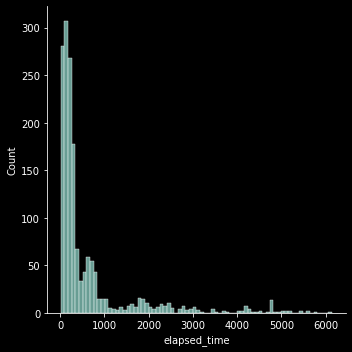

In [22]:
sns.displot(y_train)

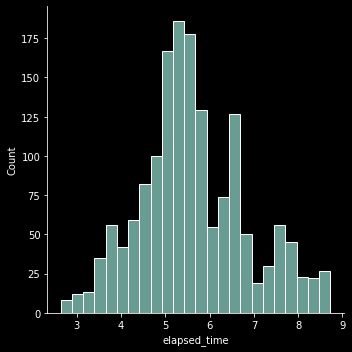

In [23]:
sns.displot(np.log(y_train))

In [24]:
y_train_log = np.log(y_train)

In [25]:
y_train_log

0       6.483107
1       5.638355
13      5.170484
14      4.143135
15      4.595120
          ...   
1940    3.688879
1941    4.499810
1942    4.948760
1943    5.420535
1944    4.007333
Name: elapsed_time, Length: 1595, dtype: float64

## Scaler ##

In [26]:
# min_max = MinMaxScaler()

In [27]:
# min_max.fit(X_train)

In [28]:
# X_train_scaled = min_max.transform(X_train)
# X_test_scaled = min_max.transform(X_test)

#### Algos

In [29]:
reg = LinearRegression()
reg.fit(X_train,y_train_log)
y_pred_reg_log = reg.predict(X_test)

In [30]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train,y_train_log)
y_pred_xgb_log = xgb_reg.predict(X_test)

In [31]:
forrest_reg = RandomForestRegressor()
forrest_reg.fit(X_train,y_train_log)
y_pred_forrest_log = forrest_reg.predict(X_test)

In [32]:
mae_reg = mean_absolute_error(y_test,np.exp(y_pred_reg_log))
mape_reg = mean_absolute_percentage_error(y_test, np.exp(y_pred_reg_log))
rmse_reg  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_reg_log)))
print(f'mae_reg : {mae_reg}')
print(f'mape_reg : {mape_reg}')
print(f'rmse_reg: {rmse_reg}')

mae_reg : 623.807504402496
mape_reg : 0.7514340717471393
rmse_reg: 2245.1759914227496


In [33]:
mae_xgb = mean_absolute_error(y_test,np.exp(y_pred_xgb_log))
mape_xgb = mean_absolute_percentage_error(y_test, np.exp(y_pred_xgb_log))
rmse_xgb  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_xgb_log)))
print(f'mae_xgb : {mae_xgb}')
print(f'mape_xgb: {mape_xgb}')
print(f'rmse_xgb: {rmse_xgb}')

mae_xgb : 117.5657731791905
mape_xgb: 0.18526422159714062
rmse_xgb: 309.3431638944878


In [34]:
mae_forrest = mean_absolute_error(y_test,np.exp(y_pred_forrest_log))
mape_forrest = mean_absolute_percentage_error(y_test, np.exp(y_pred_forrest_log))
rmse_forrest  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_forrest_log)))
print(f'mae_forrest : {mae_forrest}')
print(f'mape_forrest: {mape_forrest}')
print(f'rmse_forrest: {rmse_forrest}')

mae_forrest : 106.91539783375504
mape_forrest: 0.19233346197361048
rmse_forrest: 248.11889184697912


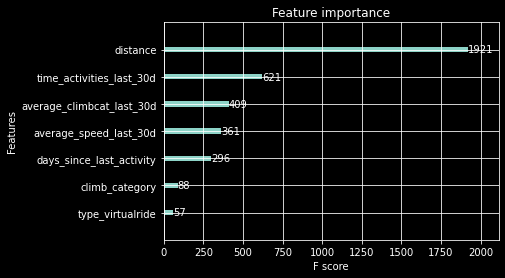

In [35]:
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [36]:
data = {
    'MAE':[mae_naive,mae_reg,mae_xgb,mae_forrest],
    'MAPE':[mape_naive,mape_reg,mape_xgb,mape_forrest],
    'RMSE':[rmse_naive,rmse_reg,rmse_xgb,rmse_forrest]
}

comparaison_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','forrest'])
comparaison_df.sort_values(by=['MAPE'])

,MAE,MAPE,RMSE
xgbreg,117.565773,0.185264,309.343164
forrest,106.915398,0.192333,248.118892
naive,258.330868,0.368048,559.476082
linreg,623.807504,0.751434,2245.175991


### Prediction Alpe d'huez

In [37]:
query = {
    "query": {
        "match": {
            "_id": 2787335981548134218
        }
    }
}

result = database.search(
    index="index_route",
    size=1000,
    body= query
)

route_alpe = result['hits']['hits'][0]['_source']
segments_alpe = route_alpe.get("segmentation")
segments_alpe_df = pd.DataFrame(segments_alpe)
segments_alpe_df

,distance,altitude_gain,average_grade,all_points
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000..."
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45...."
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45..."
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000..."


**Time Activities last 30d and Avg Speed**

In [38]:
today = date.today()
end_date = today - timedelta(days=1)
start_date = end_date - timedelta(days=30)

In [39]:
activities_last_30d = activities_df[activities_df['start_date'].between(start_date,end_date)]
time_activities_last_30d = round((activities_last_30d['elapsed_time'].sum()/60),2)

result = activities_last_30d['average_speed'].mean()
if np.isnan(result):
    average_speed_last_30d = 0
else:
    average_speed_last_30d = result

In [40]:
segments_alpe_df['time_activities_last_30d'] = time_activities_last_30d
segments_alpe_df['average_speed_last_30d'] = average_speed_last_30d
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",86.95,7.569
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",86.95,7.569
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",86.95,7.569
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",86.95,7.569


**Home Trainer**

In [41]:
segments_alpe_df['type_virtualride'] = 1
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d,type_virtualride
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",86.95,7.569,1
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",86.95,7.569,1
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",86.95,7.569,1
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",86.95,7.569,1


**Climb Category**

In [42]:
climb_category = []
for average_grade, distance in zip(segments_alpe_df['average_grade'],segments_alpe_df['distance']):
    result = average_grade * distance
    if result <= 8000:
        climb_cat = 0
    elif result > 8000 and result <= 16000:
        climb_cat = 4
    elif result > 16000 and result <= 32000:
        climb_cat = 3
    elif result > 32000 and result <= 64000:
        climb_cat = 2
    elif result > 64000 and result <= 80000:
        climb_cat = 1
    elif result > 80000:
        climb_cat = 5
    climb_category.append(climb_cat)
climb_category

[0, 0, 0, 5]

In [43]:
segments_alpe_df['climb_category'] = climb_category
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d,type_virtualride,climb_category
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",86.95,7.569,1,0
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",86.95,7.569,1,0
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",86.95,7.569,1,0
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",86.95,7.569,1,5


**Days since last_activities**

In [44]:
result = date.today() - activities_df.loc[0]['start_date']
segments_alpe_df['days_since_last_activity'] = result.days
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d,type_virtualride,climb_category,days_since_last_activity
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",86.95,7.569,1,0,66
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",86.95,7.569,1,0,66
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",86.95,7.569,1,0,66
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",86.95,7.569,1,5,66


**AVg climb Last30D**

In [45]:
segments_alpe_df['average_climbcat_last_30d'] = round(segments_df[segments_df['start_date'].between(start_date,end_date)]['climb_category'].mean(),2)

In [46]:
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d,type_virtualride,climb_category,days_since_last_activity,average_climbcat_last_30d
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",86.95,7.569,1,0,66,1.0
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",86.95,7.569,1,0,66,1.0
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",86.95,7.569,1,0,66,1.0
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",86.95,7.569,1,5,66,1.0


**Prediction**

In [47]:
cols_to_predict = ['distance','climb_category','type_virtualride','time_activities_last_30d','days_since_last_activity','average_climbcat_last_30d','average_speed_last_30d']
datas = segments_alpe_df[cols_to_predict]
datas

,distance,climb_category,type_virtualride,time_activities_last_30d,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d
0,270.55,0,1,86.95,66,1.0,7.569
1,422.22,0,1,86.95,66,1.0,7.569
2,427.89,0,1,86.95,66,1.0,7.569
3,12615.51,5,1,86.95,66,1.0,7.569


In [48]:
alpe_pred_reg = reg.predict(datas)
elapsed_time_reg = relativedelta(seconds=(np.exp(alpe_pred_reg)).sum())
elapsed_time_reg

relativedelta(hours=+2, minutes=+7, seconds=+9.02609)

In [49]:
alpe_pred_xgb = xgb_reg.predict(datas)
elapsed_time_xgb = relativedelta(seconds=(np.exp(alpe_pred_xgb)).sum())
elapsed_time_xgb

relativedelta(hours=+1, minutes=+6, seconds=+1.34473)

In [50]:
alpe_pred_forrest = forrest_reg.predict(datas)
elapsed_time_forrest = relativedelta(seconds=(np.exp(alpe_pred_forrest)).sum())
elapsed_time_forrest

relativedelta(hours=+1, minutes=+22, seconds=+40.7047)

In [51]:
elapsed_time_naive

relativedelta(minutes=+38, seconds=+30.4169)

In [52]:
def format_hms_relativedelta(relative_delta):
    hour = int(relative_delta.hours)
    minutes = int(relative_delta.minutes)
    seconds = int(relative_delta.seconds)
    print(f'Prediction {hour}h{minutes}m{seconds}sec')
    return f'{hour}h{minutes}m{seconds}sec'

In [53]:
def compute_kmh(time,distance):
    return (distance/time)*3.6

In [54]:
def compute_pred_seconds(pred):
    return round(np.exp(pred).sum(),2)

In [55]:
distance = segments_alpe_df['distance'].sum()
distance

13736.17

In [56]:
data = {
    'Prediction':[
                  format_hms_relativedelta(elapsed_time_naive),
                  format_hms_relativedelta(elapsed_time_reg),
                  format_hms_relativedelta(elapsed_time_xgb),
                  format_hms_relativedelta(elapsed_time_forrest),
                  '0h31m39s'
                 ],
    'Mean_speed(km/h)':[
                        distance / elapsed_time_pred_naive_sec * 3.6,
                        compute_kmh(compute_pred_seconds(alpe_pred_reg),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_xgb),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_forrest),distance),
                        distance / 1899 * 3.6
                        ]
}

comparaison_pred_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','forrest','strava'])
comparaison_pred_df

Prediction 0h38m30sec
Prediction 2h7m9sec
Prediction 1h6m1sec
Prediction 1h22m40sec


,Prediction,Mean_speed(km/h)
naive,0h38m30sec,21.403155
linreg,2h7m9sec,6.481848
xgbreg,1h6m1sec,12.483203
forrest,1h22m40sec,9.968394
strava,0h31m39s,26.040133
